In [40]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

font_t = {'weight' : 'bold'}

# Read votes

# vd = pd.read_csv('_votesData.csv',index_col=0,dtype={'SubjectID':str,'W':int,'H':int,'Q':str}).reset_index(drop=True)
# vd.head()


In [28]:
td = pd.read_csv('/Users/zhangjiayu/Desktop/toGenHeatmap.csv',index_col=0,dtype={'SubjectID':str,'TrackID':str}).reset_index(drop=True)

#td.loc[td.Pitch>0,'Pitch'] = td[td.Pitch>0]['Pitch']-np.pi # Fix overflow bug
#td.loc['Pitch']=td.Pitch+np.pi/2
td.head()

File  Grade        TrackID  \
0  sitzmann_0007_equirec_8192x4096_jpeg_q90.jpg      3  1544765692446   
1  sitzmann_0007_equirec_8192x4096_jpeg_q90.jpg      3  1544765692446   
2  sitzmann_0007_equirec_8192x4096_jpeg_q90.jpg      3  1544765692446   
3  sitzmann_0007_equirec_8192x4096_jpeg_q90.jpg      3  1544765692446   
4  sitzmann_0007_equirec_8192x4096_jpeg_q90.jpg      3  1544765692446   

  SubjectID  Timestamp      Roll       Yaw     Pitch       track_id  
0         0          0  0.000000  0.000000  0.000000  1544765692446  
1         0         34  0.012739  2.258151 -0.076502  1544765692446  
2         0         67  0.014423  2.256169 -0.082431  1544765692446  
3         0        101  0.016244  2.255958 -0.087472  1544765692446  
4         0        135  0.017880  2.258699 -0.090353  1544765692446

In [32]:

# Convert tracks data frame to numpy

subjects = set(td['SubjectID'])
files = set(td['File'])

for f in files:
    df = td[td.File==f]
    tracks = set(df['TrackID'])
    print(f,len(tracks))
    #continue
    for t in tracks:
        print(t)
        # print(s,t)
        df = df[df.TrackID==t]
        npTrack = np.asarray(df[['Timestamp','Yaw','Pitch','Roll']])
        break
    break


sitzmann_0002_equirec_8192x4096_jpeg_q15.jpg 20
1544725681678


In [36]:
def rn_st(s):
    d = {'0002':'Seashore', '0004':'Swimming Pool', '0006':'Chess', '0007':'Clock Tower', '0012':'Bedroom', 
         '0013':'Snow', '0015':'Shark', '0016':'Office', '0018':'Railway', '0019':'Cabin'}
    return d[s]


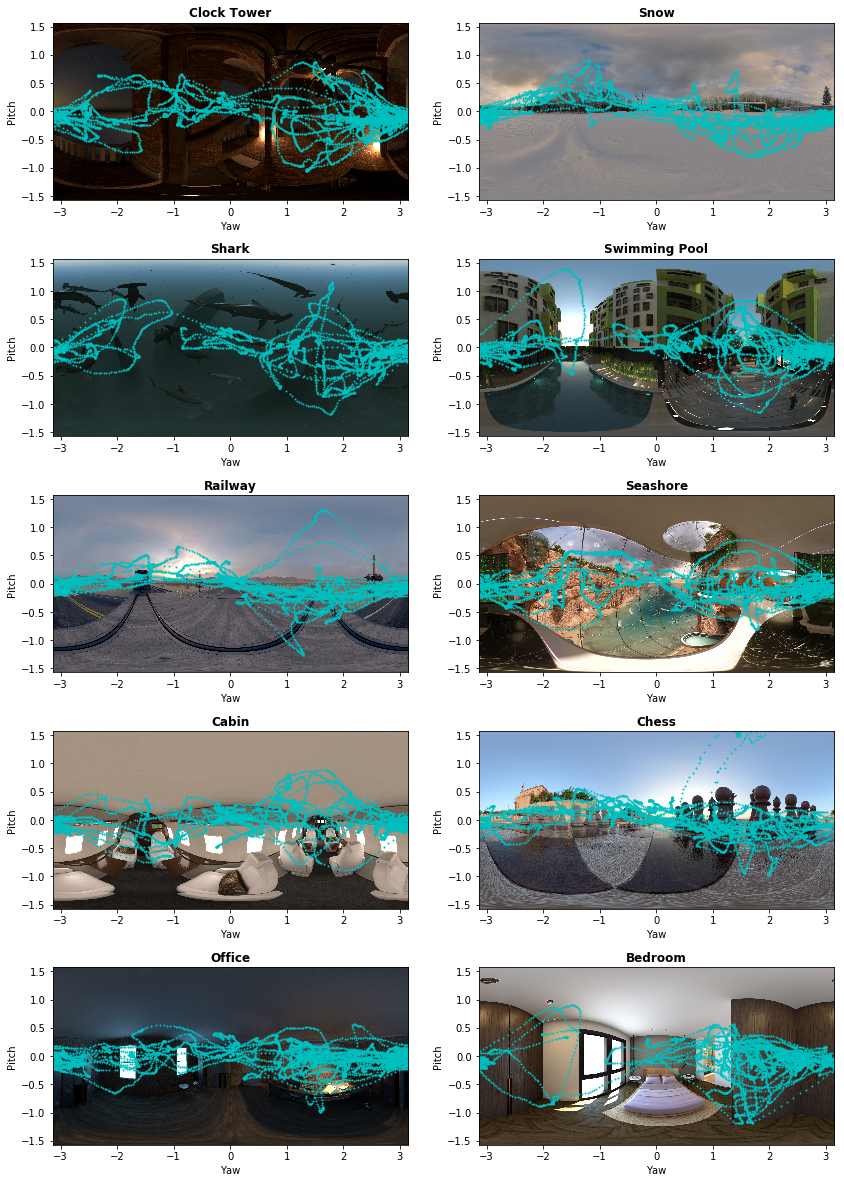

In [41]:
# plot the data
fig = plt.figure(figsize=(14,21))
count = 1
for i,f in enumerate(files):
    if f[-7:-4] == "q90":
        df = td[td.File==f]
        ax = fig.add_subplot(5, 2, count)
        count = count + 1
        img = plt.imread('/Users/zhangjiayu/Desktop/4/stimuli/evaluation/'+f)
        ax.imshow(img,extent=[-np.pi, np.pi, -np.pi/2, np.pi/2])
        ax.scatter(x=df.Yaw,y=(df.Pitch),s=1,c='c')
        plt.xlim((-np.pi,np.pi))
        plt.ylim((-np.pi/2,np.pi/2))
        plt.xlabel('Yaw')
        plt.ylabel('Pitch')
        name = rn_st(f.split('_')[1])
        # print(name)
        plt.title(name, **font_t)
plt.show()
fig.savefig("/Users/zhangjiayu/Desktop/toGenHeat1.png", dpi = 600)



In [22]:
from scipy import signal

tracks = set(td.TrackID)
td2 = td
td2['V'] = 0
td2['Significant'] = True

threshold = 20 # Degrees per second

for track in tracks:
    df = td[td.TrackID==track]
    # Time variable
    t = df.Timestamp * 0.001

    # X and Y components
    x = np.asarray(df.Pitch)
    y = np.asarray(df.Yaw)

    # Compute partial derivatives
    dx = np.diff(x)/np.diff(t)
    dy = np.diff(y)/np.diff(t)
    # print (len(dx), len(dy))
    # print (dx, dy)

    # Filter differentiantion noise
    b, a = signal.butter(8, 0.125)
    dx_filt = signal.filtfilt(b, a, dx)
    dy_filt = signal.filtfilt(b, a, dy)
    
    # dx_filt = signal.filtfilt(b, a, dx, padlen=110)
    # dy_filt = signal.filtfilt(b, a, dy, padlen=110)

    # Compute velocity
    v = np.sqrt(dx_filt**2+dy_filt**2)
    v = v*180/np.pi # Dergrees per second
    v = np.insert(v, 0, 0)
    
    td2.loc[td.TrackID==track,'V'] = v
    td2.loc[td.TrackID==track,'Significant'] = (v <= threshold)
    
    #print("Track "+track+" Done.")



/Users/zhangjiayu/anaconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


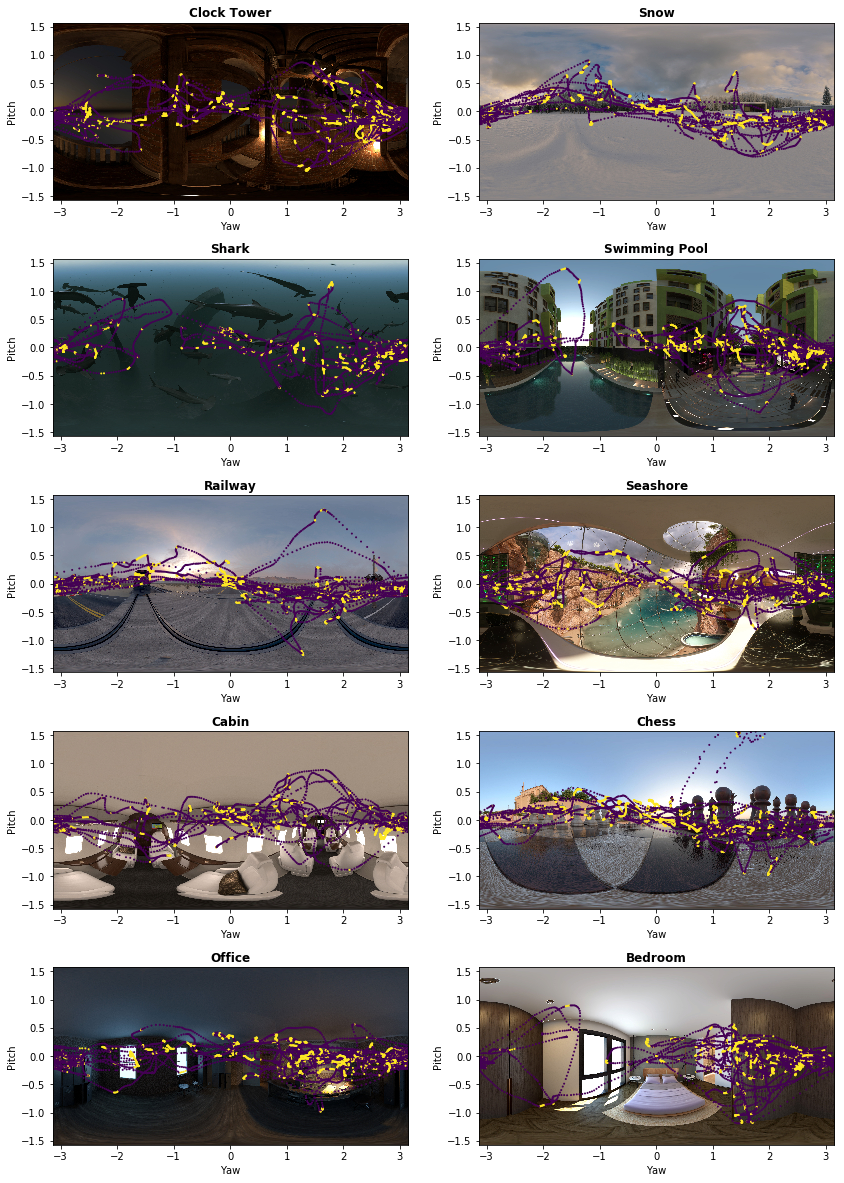

In [43]:
# plot the data
fig = plt.figure(figsize=(14,21))
count = 1
for i,f in enumerate(files):
    if f[-7:-4] == "q90":
        df = td2[td2.File==f]
        ax = fig.add_subplot(5, 2, count)
        count = count + 1
        img = plt.imread('/Users/zhangjiayu/Desktop/4/stimuli/evaluation/'+f)
        ax.imshow(img,extent=[-np.pi, np.pi, -np.pi/2, np.pi/2])
        ax.scatter(x=df.Yaw,y=df.Pitch,s=1,c=df.Significant)
        plt.xlim((-np.pi,np.pi))
        plt.ylim((-np.pi/2,np.pi/2))
        plt.xlabel('Yaw')
        plt.ylabel('Pitch')
        name = rn_st(f.split('_')[1])
        plt.title(name, **font_t)
plt.show()
fig.savefig("/Users/zhangjiayu/Desktop/toGenHeat2.png", dpi = 600)


In [44]:
W = 8192
H = 4096
points = dict()
fused = dict()
for f in files:
    fixs = np.asarray(td2[(td2.File==f)&td2.Significant][['Yaw','Pitch']])
    print (fixs.size)
    points[f] = fixs
    yaw, pitch = zip(*fixs)
    yaw = np.asarray(yaw)
    pitch = np.asarray(pitch)
    print(yaw.size, pitch.size)
    yaw_q = ((yaw/np.pi) * (W/2)).astype(int) + 4096
    pitch_q = ((pitch/np.pi) * (H/2)).astype(int) + 2048
    print(yaw_q, pitch_q)
    
    # yaw_q = np.round((yaw/np.pi + 1)*(W/2)).astype(int)
    # pitch_q = np.round((0.5 - pitch/np.pi/2)*(H/2)).astype(int)
    
    
    # yaw_q = np.round((yaw/np.pi/2 + 1)*(W/2)).astype(int)
    # pitch_q = np.round((0.5 - pitch/np.pi)*(H/2)).astype(int)
    
    # yaw_q = np.round((0.5-yaw/np.pi/2)*W).astype(int)
    # pitch_q = np.round((pitch/np.pi + 1)*H).astype(int)
    print(yaw_q.size, pitch_q.size)
    # pitch_q = np.round((pitch/np.pi+1)*H).astype(int)
    image = np.zeros((H, W))
    image[pitch_q,yaw_q] = 1
    fused[f] = image
    #fixs_quant = list(set(zip(pitch_q,yaw_q)))


6450
3225 3225
[4096 7298 5461 ... 5361 5364 5364] [2048 2087 1931 ... 2109 2111 2112]
3225 3225
2254
1127 1127
[4096 7587 7576 ... 6679 6678 6679] [2048 2111 2110 ... 2133 2132 2132]
1127 1127
7084
3542 3542
[4096 7042 7092 ...  728  730  733] [2048 1984 1957 ... 2083 2082 2081]
3542 3542
4532
2266 2266
[4096  177  139 ... 7552 7553 7555] [2048 2031 2041 ... 2030 2030 2031]
2266 2266
4960
2480 2480
[4096 4096 8156 ... 6691 6692 6694] [2048 2048 2016 ... 1994 1994 1994]
2480 2480
6072
3036 3036
[4096  414  908 ... 4646 4645 4648] [2048 1960 1956 ... 2016 2015 2016]
3036 3036
4566
2283 2283
[4096 4096 6330 ... 7743 7743 7744] [2048 2048 1853 ... 2069 2068 2068]
2283 2283
4672
2336 2336
[4096 8076 7256 ... 2377 2376 2380] [2048 1981 2041 ... 2180 2178 2174]
2336 2336
2102
1051 1051
[4096 6115 5806 ... 2742 2742 2743] [2048 1945 2097 ... 2009 2008 2007]
1051 1051
4386
2193 2193
[4096 8097 7869 ... 7985 7985 7989] [2048 1977 2006 ... 2047 2048 2047]
2193 2193
5996
2998 2998
[4096 6168 5486

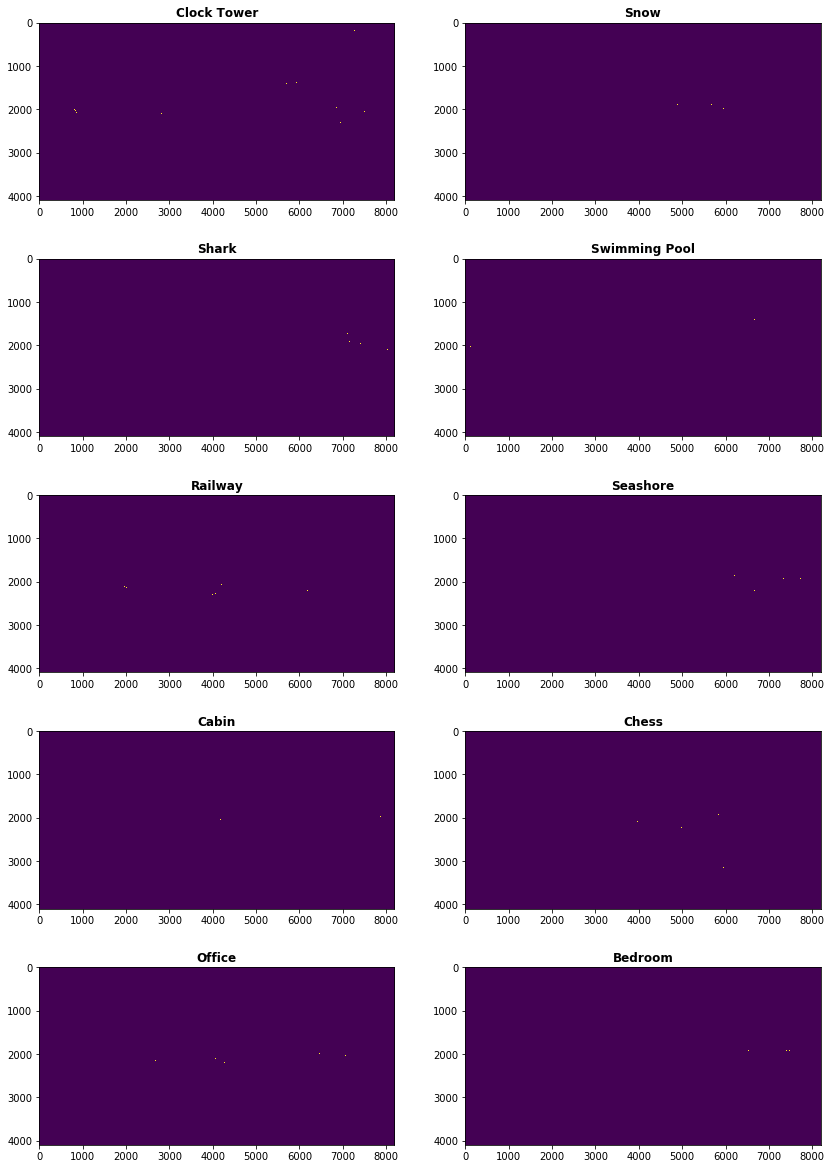

In [46]:
fig = plt.figure(figsize=(14,21))
count = 1
for i,f in enumerate(files):
    if f[-7:-4] == "q90":
        ax = fig.add_subplot(5, 2, count)
        count = count + 1
        #img = plt.imread('../images/'+f)
        ax.imshow(fused[f])
        name = rn_st(f.split('_')[1])
        plt.title(name, **font_t)
plt.show()

In [47]:
from scipy.ndimage.filters import gaussian_filter

sigma = 30*(W/360) # 30 degrees

    
heatmaps = dict()

for f in files:
    if f[-7:-4] == "q90":
 
        print("Filtering "+f+" ...")
        # blurred = gaussian_filter(fused[f], sigma=sigma)
        blurred = gaussian_filter(fused[f], sigma=sigma)
        blurred *= 1.0/blurred.max()
        heatmaps['sitzmann' + f[9:13]] = blurred
        
    


Filtering sitzmann_0007_equirec_8192x4096_jpeg_q90.jpg ...
Filtering sitzmann_0013_equirec_8192x4096_jpeg_q90.jpg ...
Filtering sitzmann_0015_equirec_8192x4096_jpeg_q90.jpg ...
Filtering sitzmann_0004_equirec_8192x4096_jpeg_q90.jpg ...
Filtering sitzmann_0018_equirec_8192x4096_jpeg_q90.jpg ...
Filtering sitzmann_0002_equirec_8192x4096_jpeg_q90.jpg ...
Filtering sitzmann_0019_equirec_8192x4096_jpeg_q90.jpg ...
Filtering sitzmann_0006_equirec_8192x4096_jpeg_q90.jpg ...
Filtering sitzmann_0016_equirec_8192x4096_jpeg_q90.jpg ...
Filtering sitzmann_0012_equirec_8192x4096_jpeg_q90.jpg ...


In [48]:
np.save('/Users/zhangjiayu/Desktop/jiayu_heatmaps.npy',heatmaps)

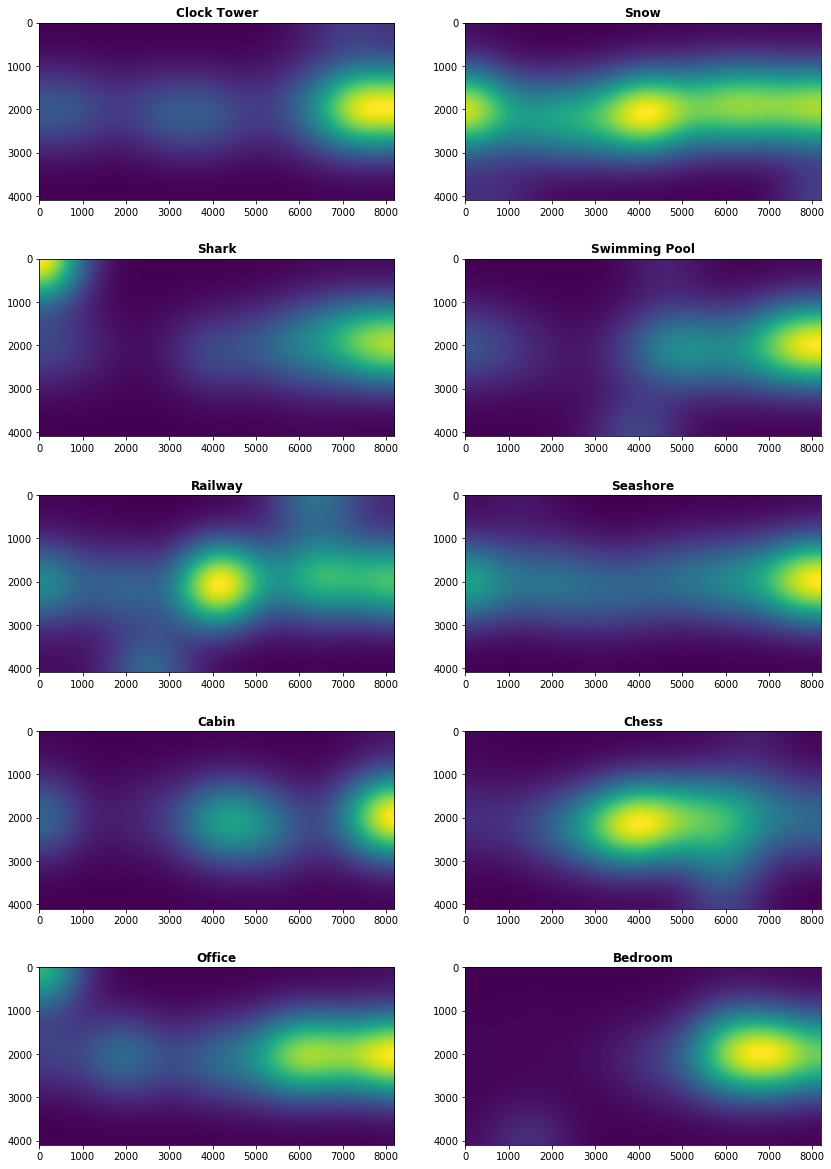

In [54]:
fig = plt.figure(figsize=(14,21))
count = 1
heatmaps = np.load('/Users/zhangjiayu/Desktop/jiayu_heatmaps.npy', encoding = "latin1").item()
for i,f in enumerate(files):
    if f[-7:-4] == "q90":
        ax = fig.add_subplot(5, 2, count)
        #img = plt.imread('../images/'+f)
        ax.imshow(heatmaps['sitzmann' + f[9:13]])
        name = rn_st(f.split('_')[1])
        plt.title(name, **font_t)
        count = count + 1
plt.show()
fig.savefig("/Users/zhangjiayu/Desktop/jiayu_heatmap.png", dpi = 600)

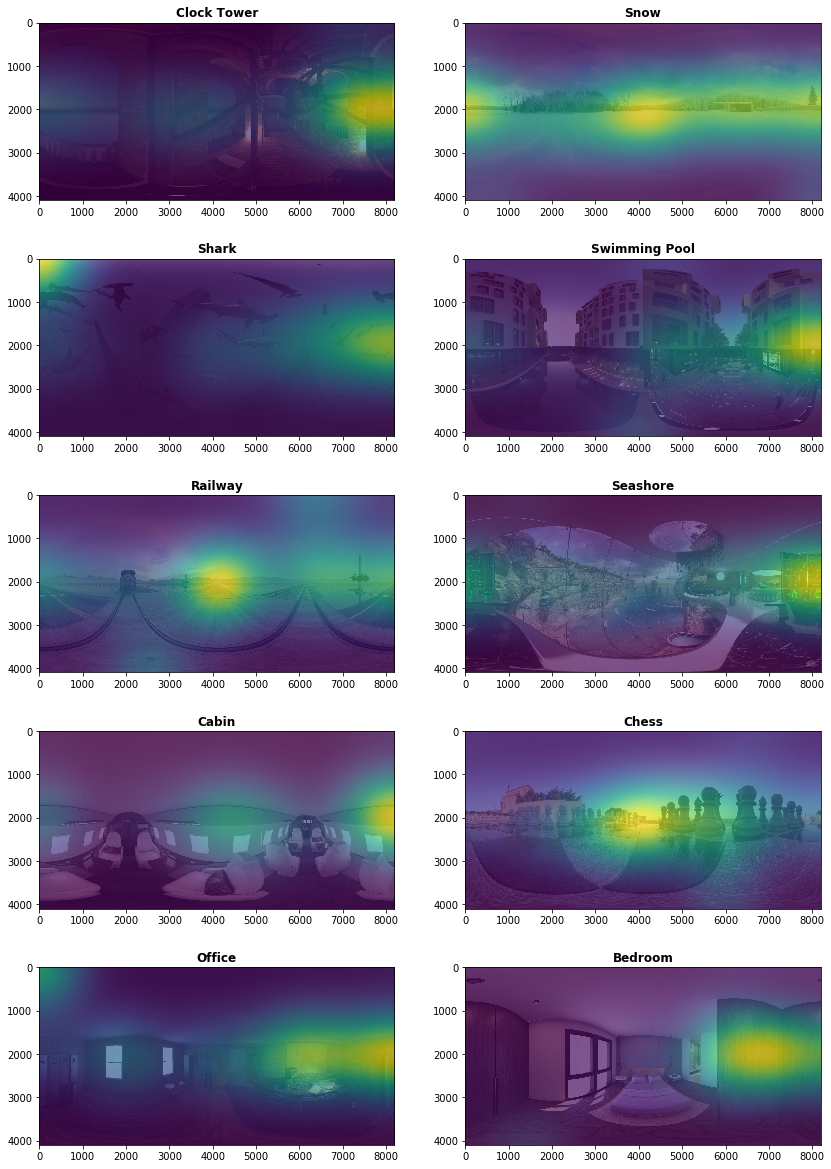

In [55]:
fig = plt.figure(figsize=(14,21))

count = 1
for i,f in enumerate(files):
    if f[-7:-4] == "q90":
        ax = fig.add_subplot(5, 2, count)
        img = plt.imread('/Users/zhangjiayu/Desktop/4/stimuli/evaluation/'+f)
        ax.imshow(img)
        ax.imshow(heatmaps['sitzmann' + f[9:13]],alpha=0.7)
        name = rn_st(f.split('_')[1])
        plt.title(name, **font_t)
        count = count + 1
plt.show()
fig.savefig("/Users/zhangjiayu/Desktop/jiayu_heatmapWB.png", dpi = 600)